In [1]:
%load_ext watermark

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import pymc3 as pm
import scipy as sp
import seaborn as sns
import theano.tensor as tt
import warnings

from scipy.special import expit as logistic
from scipy.special import softmax

warnings.simplefilter(action="ignore", category=FutureWarning)
RANDOM_SEED = 8927
np.random.seed(286)

PARTIES = ["farleft", "left", "green", "center", "right", "farright", "other"]
PARTIES_AGG = [
    "farleft_agg",
    "left_agg",
    "green_agg",
    "center_agg",
    "right_agg",
    "farright_agg",
]

In [2]:
az.style.use("arviz-darkgrid")


def stdz(series: pd.Series) -> pd.Series:
    """Standardize the given pandas Series"""
    return (series - series.mean()) / series.std()

Let's load the data and transform every missing values to 0: except for the "other" category, when a party is missing, this means that it got 0 votes, so it makes sense to replace NaNs by 0s. Note however that these zeros do not come from the multinomial process - unlike the zeros in the "other" category, but from an earlier process that determines if any given party competes in the election. We'll deal with that below, but let's already remark that this looks a lot like a zero-inflated process...

In [175]:
d = pd.read_excel("../data/results_by_districts_paris.xlsx", index_col=0)
# a party that wasn't there won 0 ballots:
d[PARTIES] = d[PARTIES].fillna(0).astype(int)

# keep track of which party was the incumbent for each election:
INCUMBENTS = {
    date: incumbent
    for date, incumbent in zip(
        d.date.unique(),
        [
            "right",
            "right",
            "left",
            "left",
            "left",
            "right",
            "right",
            "left",
            "right",
            "left",
            "left",
            "left",
        ],
    )
}
for date, incumbent in INCUMBENTS.items():
    d.loc[d.date == date, "incumbent"] = incumbent
right_inc = pd.Categorical(d.incumbent).codes
left_inc = 1 - right_inc

d["N"] = d[PARTIES].div(50).round().sum(1)
d[PARTIES] = d[PARTIES].div(50).round()
d

date  ville  arrondissement       N  farleft   left  green  center  \
0   2007-04-22  Paris               1   183.0      5.0   51.0    4.0    41.0   
1   2007-06-10  Paris               1   136.0      5.0    0.0   39.0    16.0   
2   2008-03-09  Paris               1   124.0      2.0   46.0    9.0    11.0   
3   2009-06-07  Paris               1   104.0      6.0   13.0   30.0     8.0   
4   2010-03-14  Paris               1    98.0      6.0   22.0   21.0     4.0   
..         ...    ...             ...     ...      ...    ...    ...     ...   
235 2014-03-23  Paris              20  1099.0    114.0  410.0  120.0     0.0   
236 2014-05-25  Paris              20   982.0     99.0  212.0  190.0    84.0   
237 2015-12-06  Paris              20   983.0    122.0  366.0  147.0     0.0   
238 2017-04-23  Paris              20  1791.0    570.0  249.0    0.0   548.0   
239 2017-06-11  Paris              20  1148.0    231.0  214.0  155.0   130.0   

     right  farright  other         type incumbent  
0     72.0       8.0    2.0    president     right  
1     69.0       3.0    4.0  legislative     right  
2     53.0       3.0    0.0   municipale      left  
3     36.0       3.0    8.0     european      left  
4     35.0       5.0    5.0     regional      left  
..     ...       ...    ...          ...       ...  
235  229.0      82.0  144.0   municipale      left  
236  120.0      92.0  185.0     european     right  
237  167.0     100.0   81.0     regional      left  
238  229.0     106.0   89.0    president      left  
239   86.0      49.0  283.0  legislative      left  

[240 rows x 13 columns]

What's the proportion of zeros in the respective categories?

In [115]:
1 - d[PARTIES].astype(bool).mean(axis=0).round(2)

farleft     0.02
left        0.02
green       0.08
center      0.17
right       0.00
farright    0.00
other       0.02
dtype: float64

Note that zeros in the category "other" are real multinomial zeros, while zeros in farleft, green and center result from the absence of these categories in the multinomial - they were eliminated upstream from the multinomial trials and are therefore not real multinomial zeros. Also note that the zero-inflated categories are not "jointly-inflated" (green is not necessaricly 0 when center is, and vice-versa).

Now let's look at each category's distribution (we zoom-in to really see zero-inflations):

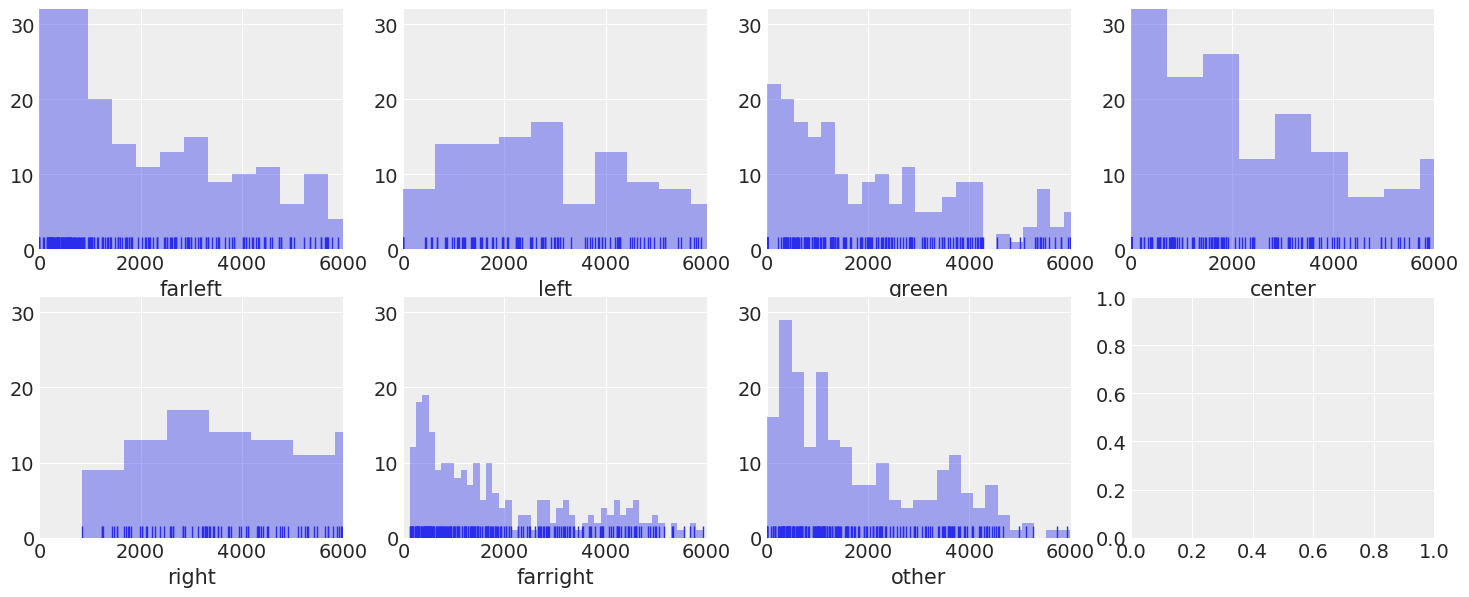

In [5]:
fig, axes = plt.subplots(2, 4, figsize=(18, 7))
i = 0
for line in axes:
    for col in line:
        try:
            sns.distplot(d[PARTIES[i]], bins=60, kde=False, rug=True, ax=col)
            col.set_xlim([0, 6_000])
            col.set_ylim([0, 32])
            i += 1
        except IndexError:
            continue

That's not the best plot, but we can see that farleft, green and center do have a tendency to zero-inflation. The zero inflation comes from the fact that sometimes, some parties don't compete in a given election. Here, this process is simulated exactly like it happened in reality for the four elections in our dataset - thanks to the variable `parties_available`. So, during the four elections, some parties are not available in all or some districts. Now, how can we model this mixed process?

First, let's define index variables:

In [176]:
district_id, districts = d.arrondissement.factorize(sort=True)
Ndistricts = len(districts)

type_id, types = d.type.factorize(sort=True)
Ntypes = len(types)

Nparties = len(PARTIES) - 1
N = d.N.values
R_obs = d[PARTIES].values

# which parties are available for choice
# huge value for missing parties, so that probability is 0 after softmax:
parties_available = d[PARTIES].astype(bool).astype(int).iloc[:, :-1].replace(to_replace=0, value=50_000).values
parties_available

array([[    1,     1,     1,     1,     1,     1],
       [    1, 50000,     1,     1,     1,     1],
       [    1,     1,     1,     1,     1,     1],
       ...,
       [    1,     1,     1, 50000,     1,     1],
       [    1,     1, 50000,     1,     1,     1],
       [    1,     1,     1,     1,     1,     1]])

Then we add a predictor to the dataset, which is the unemployment rate in Paris on a quarterly basis:

In [117]:
unemp = pd.read_excel(
    "../data/predictors/chomage-zone-demploi-2003-2019.xls",
    header=5,
    sheet_name="txcho_ze",
)
unemp = unemp[unemp["LIBZE2010"] == "Paris"].iloc[:, 4:].T
unemp.columns = ["unemployment"]

# as timestamps variables:
unemp.index = pd.PeriodIndex(start=unemp.index[0], periods=len(unemp), freq="Q")
unemp

unemployment
2003Q1           8.4
2003Q2           8.7
2003Q3           8.6
2003Q4           9.0
2004Q1           9.2
...              ...
2018Q2           7.8
2018Q3           7.8
2018Q4           7.5
2019Q1           7.4
2019Q2           7.2

[66 rows x 1 columns]

Now ne need to import the poll aggregation for each election. This will be our baseline for each party in each district:

In [118]:
train_polls = pd.read_excel(
    "../data/polls_1st_round/aggregated_polls.xlsx", index_col=0
)

test_polls = pd.read_excel(
    "/Users/alex_andorra/repos/contesdefaits/modeles/euro/agg_polls_euro2019.xlsx"
).iloc[-1]
test_polls = test_polls.drop(["souv", "other"])
test_polls.index = train_polls.columns[1:]
test_polls["type"] = "europeennes"

aggregated_polls = train_polls.append(test_polls, ignore_index=True)
aggregated_polls[PARTIES_AGG] = aggregated_polls[PARTIES_AGG].div(100)
aggregated_polls.round(2)

type dateelection  samplesize_agg  farleft_agg  left_agg  \
0      president   2007-04-22            1513         0.03      0.24   
1   legislatives   2007-06-10             916         0.07      0.28   
2     municipale   2008-03-09             755         0.04      0.45   
3    europeennes   2009-06-07            2287         0.13      0.20   
4     regionales   2010-03-14             907         0.10      0.29   
5      president   2012-04-22            1400         0.14      0.28   
6   legislatives   2012-06-10            1193         0.08      0.32   
7     municipale   2014-03-23             977         0.06      0.38   
8    europeennes   2014-05-25            3248         0.08      0.17   
9     regionales   2015-12-06            1749         0.05      0.23   
10     president   2017-04-23            1555         0.19      0.08   
11  legislatives   2017-06-11            1299         0.12      0.08   
12   europeennes   2019-05-25            2221         0.08      0.05   

    green_agg  center_agg  right_agg  farright_agg  
0        0.01        0.19       0.27          0.14  
1        0.04        0.11       0.41          0.06  
2        0.06        0.08       0.33          0.02  
3        0.13        0.11       0.27          0.06  
4        0.14        0.05       0.29          0.09  
5        0.03        0.10       0.27          0.16  
6        0.05        0.03       0.34          0.15  
7        0.07        0.00       0.37          0.08  
8        0.09        0.10       0.21          0.23  
9        0.06        0.00       0.28          0.29  
10       0.00        0.24       0.19          0.22  
11       0.03        0.30       0.21          0.17  
12       0.08        0.23       0.14          0.25

As you probably noticed, the polls are in shares of support. Since our link function is softmax, we need to convert these proportions back on the real line (because the polls will be used before the link function appears in our model). It's [really easy to invert the softmax](https://math.stackexchange.com/questions/2786600/invert-the-softmax-function): we just have to take the log of each proportion and add an arbitrary constant -- here, we chose 1.

But hold on! There are two zeros in these data (for center party during the 2014 city-council and 2015 regional elections). It's due to the fact that this party was not running during these elections. When we'll take the logarithm of these zeros, we'll get minus infinity -- spoiler alert: our sampler won't like that. So we'll have to use a trick here.

Notice that the green party has a very low share of polls in the 2017 presidential elections. It's because there were some polls featuring the green party at the beginning of the race, but not anymore once the party dropped out. This is useful for us here: as a results, the poll aggregation is very near zero but not _exactly_ zero, so on the log scale it will give a very negative number but not minus infinity.

So here is our trick: let's replace the zeros for the center party by the value for the green party during the 2017 presidential election. This might seem like a cheap trick but it actually makes some conceptual sense: our model is concerned with the _latent_ support of each party's in the population. And in reality, neither the center nor the green parties were at _exactly_ zero percent support during these years -- they just had a very low support, which actually forced them to drop out and make alliances. So, replacing our perfect zeros with not-so-perfect zeros does make sense!

Here is how it looks in code:

In [119]:
aggregated_polls[PARTIES_AGG] = aggregated_polls[PARTIES_AGG].replace(
    to_replace=0, value=aggregated_polls.loc[aggregated_polls.dateelection == "2017-04-23", "green_agg"].values[0]
)

# revert the softmax:
aggregated_polls[PARTIES_AGG] = aggregated_polls[PARTIES_AGG].apply(np.log) + 1

# standardize:
# aggregated_polls[PARTIES_AGG] = stdz(aggregated_polls[PARTIES_AGG])
aggregated_polls.round(2)

type dateelection  samplesize_agg  farleft_agg  left_agg  \
0      president   2007-04-22            1513        -2.63     -0.43   
1   legislatives   2007-06-10             916        -1.61     -0.29   
2     municipale   2008-03-09             755        -2.33      0.19   
3    europeennes   2009-06-07            2287        -1.04     -0.63   
4     regionales   2010-03-14             907        -1.32     -0.24   
5      president   2012-04-22            1400        -0.99     -0.29   
6   legislatives   2012-06-10            1193        -1.53     -0.14   
7     municipale   2014-03-23             977        -1.88      0.04   
8    europeennes   2014-05-25            3248        -1.58     -0.79   
9     regionales   2015-12-06            1749        -1.94     -0.47   
10     president   2017-04-23            1555        -0.67     -1.57   
11  legislatives   2017-06-11            1299        -1.14     -1.53   
12   europeennes   2019-05-25            2221        -1.48     -1.98   

    green_agg  center_agg  right_agg  farright_agg  
0       -3.95       -0.67      -0.30         -0.95  
1       -2.30       -1.20       0.12         -1.76  
2       -1.85       -1.51      -0.12         -2.82  
3       -1.01       -1.19      -0.30         -1.85  
4       -1.00       -2.06      -0.24         -1.40  
5       -2.68       -1.27      -0.32         -0.84  
6       -1.98       -2.58      -0.09         -0.88  
7       -1.73      -22.24      -0.01         -1.50  
8       -1.42       -1.33      -0.54         -0.46  
9       -1.84      -22.24      -0.27         -0.24  
10     -22.24       -0.44      -0.64         -0.49  
11      -2.51       -0.19      -0.56         -0.75  
12      -1.49       -0.48      -0.95         -0.40

And now we combine all district- and city-level predictors as well as polls and election results into the same dataframe:

In [177]:
# add quarters to results dataframe:
d.index = pd.DatetimeIndex(d["date"].values).to_period("Q")
d.index.name = "quarter"
# merge with city-level unemployment:
d = d.join(unemp).sort_values(["arrondissement", "date"]).reset_index(drop=True)

# join polling aggregation:
d = d.merge(
    aggregated_polls.drop("type", 1),
    left_on="date",
    right_on="dateelection",
    how="left",
).drop("dateelection", 1)
d

date  ville  arrondissement       N  farleft   left  green  center  \
0   2007-04-22  Paris               1   183.0      5.0   51.0    4.0    41.0   
1   2007-06-10  Paris               1   136.0      5.0    0.0   39.0    16.0   
2   2008-03-09  Paris               1   124.0      2.0   46.0    9.0    11.0   
3   2009-06-07  Paris               1   104.0      6.0   13.0   30.0     8.0   
4   2010-03-14  Paris               1    98.0      6.0   22.0   21.0     4.0   
..         ...    ...             ...     ...      ...    ...    ...     ...   
235 2014-03-23  Paris              20  1099.0    114.0  410.0  120.0     0.0   
236 2014-05-25  Paris              20   982.0     99.0  212.0  190.0    84.0   
237 2015-12-06  Paris              20   983.0    122.0  366.0  147.0     0.0   
238 2017-04-23  Paris              20  1791.0    570.0  249.0    0.0   548.0   
239 2017-06-11  Paris              20  1148.0    231.0  214.0  155.0   130.0   

     right  farright  ...         type incumbent unemployment  samplesize_agg  \
0     72.0       8.0  ...    president     right          7.8            1513   
1     69.0       3.0  ...  legislative     right          7.8             916   
2     53.0       3.0  ...   municipale      left          6.6             755   
3     36.0       3.0  ...     european      left          7.9            2287   
4     35.0       5.0  ...     regional      left          8.2             907   
..     ...       ...  ...          ...       ...          ...             ...   
235  229.0      82.0  ...   municipale      left          8.7             977   
236  120.0      92.0  ...     european     right          8.8            3248   
237  167.0     100.0  ...     regional      left          8.7            1749   
238  229.0     106.0  ...    president      left          8.0            1555   
239   86.0      49.0  ...  legislative      left          8.0            1299   

     farleft_agg  left_agg  green_agg  center_agg  right_agg  farright_agg  
0      -2.633513 -0.432471  -3.950292   -0.670963  -0.296018     -0.946153  
1      -1.613136 -0.288538  -2.295177   -1.196553   0.116238     -1.763649  
2      -2.327655  0.190572  -1.849138   -1.513482  -0.116553     -2.824834  
3      -1.040641 -0.628886  -1.013539   -1.192074  -0.299655     -1.854871  
4      -1.319981 -0.240301  -0.996263   -2.061018  -0.240266     -1.398709  
..           ...       ...        ...         ...        ...           ...  
235    -1.884055  0.037657  -1.727255  -22.243938  -0.005215     -1.496337  
236    -1.582788 -0.790411  -1.420928   -1.334419  -0.537229     -0.460404  
237    -1.943570 -0.473766  -1.836909  -22.243938  -0.268955     -0.241968  
238    -0.667318 -1.565596 -22.243938   -0.437694  -0.640817     -0.493163  
239    -1.144984 -1.528224  -2.510045   -0.191539  -0.560378     -0.747776  

[240 rows x 21 columns]

Ok, everything's ready, let's run our model! This a varying-effects model that takes into account not only the variation in slopes and intercepts, but also accounts for the *covariation between slopes and intercepts* -- it exploits additional information about the population in order to shrink in both dimensions.

In [ ]:
# euro2019 (diviser sample size results, dirichlet, meas err on results, more elections?, pop_parties?)
# + Slack 
# + rethinking Carnet --> State-space Model / HMM (manages to add time-awareness and uncertainty?)

In [178]:
with pm.Model() as m_dos_effects:
    mus_parties = []
    log_unemployment = stdz(np.log(d.unemployment)).values
    for p_id, p in enumerate(PARTIES_AGG):
        stdz_polls = stdz(d[p]).values
        
        if p in ["left_agg", "right_agg"]:
            sd_dist = pm.Exponential.dist(1.0)
            packed_chol = pm.LKJCholeskyCov(f"pchol_district_p{p_id}", eta=4, n=4, sd_dist=sd_dist)

            # compute covariance matrix:
            chol = pm.expand_packed_triangular(n=4, packed=packed_chol, lower=True)
            cov = pm.math.dot(chol, chol.T)

            # extract rho and standard deviations:
            sigma_district = pm.Deterministic(f"sigma_district_p{p_id}", tt.sqrt(tt.diag(cov)))
            corr = tt.diag(sigma_district ** -1).dot(cov.dot(tt.diag(sigma_district ** -1)))
            r = pm.Deterministic(f"Rho_district_p{p_id}", corr[np.triu_indices(n=4, k=1)])

            # average itc and slopes for each party:
            β = pm.Normal(
                f"β_p{p_id}",
                mu=np.array([-1.4, 0.0, 0.1, 0.0]),
                sd=np.array([0.5, 0.05, 0.05, 0.5]),
                shape=4,
            )
            
            # population of varying effects:
            β_district = pm.MvNormal(
                f"β_district_p{p_id}", mu=β, chol=chol, shape=(Ndistricts, 4)
            )
            type_effect = pm.Normal(
                f"type_effect_p{p_id}", mu=0., sigma=0.05, shape=Ntypes
            )
            
            if p == "right_agg":
                # linear model:
                mus_parties.append(
                    β_district[district_id, 0] + type_effect[type_id]
                    + β_district[district_id, 1] * log_unemployment
                    + β_district[district_id, 2] * stdz_polls
                    + β_district[district_id, 3] * right_inc
                )
            else:
                mus_parties.append(
                    β_district[district_id, 0] + type_effect[type_id]
                    + β_district[district_id, 1] * log_unemployment
                    + β_district[district_id, 2] * stdz_polls
                    + β_district[district_id, 3] * left_inc
                )

        else:
            sd_dist = pm.Exponential.dist(1.0)
            packed_chol = pm.LKJCholeskyCov(f"pchol_district_p{p_id}", eta=4, n=3, sd_dist=sd_dist)
            chol = pm.expand_packed_triangular(n=3, packed=packed_chol, lower=True)
            cov = pm.math.dot(chol, chol.T)
            sigma_district = pm.Deterministic(f"sigma_district_p{p_id}", tt.sqrt(tt.diag(cov)))
            corr = tt.diag(sigma_district ** -1).dot(cov.dot(tt.diag(sigma_district ** -1)))
            r = pm.Deterministic(f"Rho_district_p{p_id}", corr[np.triu_indices(n=3, k=1)])
            
            if p == "center_agg":
                β = pm.Normal(
                    f"β_p{p_id}",
                    mu=np.array([-1.4, 0.0, 0.1]),
                    sd=np.array([0.5, 0.05, 0.05]),
                    shape=3,
                )
            elif p in ["farleft_agg", "green_agg"]:
                β = pm.Normal(
                    f"β_p{p_id}",
                    mu=np.array([-1.9, 0.0, 0.1]),
                    sd=np.array([0.5, 0.05, 0.05]),
                    shape=3,
                )
            elif p == "farright_agg":
                β = pm.Normal(
                    f"β_p{p_id}",
                    mu=np.array([-2.7, 0.0, 0.0]),
                    sd=np.array([0.5, 0.05, 0.05]),
                    shape=3,
                )
            β_district = pm.MvNormal(
                f"β_district_p{p_id}", mu=β, chol=chol, shape=(Ndistricts, 3)
            )
            type_effect = pm.Normal(
                f"type_effect_p{p_id}", mu=0., sigma=0.05, shape=Ntypes
            )
            mus_parties.append(
                β_district[district_id, 0] + type_effect[type_id]
                + β_district[district_id, 1] * log_unemployment
                + β_district[district_id, 2] * stdz_polls
            )

    # zero-inflation process:
    # push non-available parties towards -inf:
    mus_parties = parties_available * tt.as_tensor_variable(mus_parties).T
    # append last category:
    #vary_pivot = tt.as_tensor_variable(np.full(shape=(Ndistricts, 1), fill_value=-3.0))
    vary_pivot = pm.Normal("vary_pivot", mu=-3., sigma=0.05, shape=(Ndistricts, 1))
    mus_parties = tt.horizontal_stack(mus_parties, vary_pivot[district_id])

    # preferences of each district, for all elections:
    p_district = pm.Deterministic("p_district", tt.nnet.softmax(mus_parties))

    R = pm.Multinomial("R", n=N, p=p_district, observed=R_obs)
    prior_checks = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

In [179]:
with m_dos_effects:
    trace_dos_effects = pm.sample(
        1000, tune=2000, cores=6, chains=2, random_seed=RANDOM_SEED, init="adapt_diag",
    )

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 6 jobs)
NUTS: [vary_pivot, type_effect_p5, β_district_p5, β_p5, pchol_district_p5, type_effect_p4, β_district_p4, β_p4, pchol_district_p4, type_effect_p3, β_district_p3, β_p3, pchol_district_p3, type_effect_p2, β_district_p2, β_p2, pchol_district_p2, type_effect_p1, β_district_p1, β_p1, pchol_district_p1, type_effect_p0, β_district_p0, β_p0, pchol_district_p0]


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [180]:
az.summary(trace_dos_effects, round_to=2)

mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
β_p0[0]            -2.77  0.23   -3.22    -2.34       0.01      0.0   1284.18   
β_p0[1]            -0.10  0.05   -0.18     0.01       0.00      0.0   2043.37   
β_p0[2]             0.36  0.04    0.29     0.43       0.00      0.0    731.82   
β_district_p0[0,0] -3.10  0.15   -3.40    -2.82       0.00      0.0   1690.74   
β_district_p0[0,1] -0.31  0.15   -0.59    -0.03       0.00      0.0   2202.00   
...                  ...   ...     ...      ...        ...      ...       ...   
p_district[239,2]   0.12  0.00    0.11     0.13       0.00      0.0   2507.51   
p_district[239,3]   0.25  0.01    0.23     0.27       0.00      0.0   2144.01   
p_district[239,4]   0.09  0.00    0.08     0.09       0.00      0.0   2592.44   
p_district[239,5]   0.06  0.00    0.05     0.06       0.00      0.0   2856.23   
p_district[239,6]   0.13  0.00    0.13     0.14       0.00      0.0   2015.10   

                     ess_sd  ess_bulk  ess_tail  r_hat  
β_p0[0]             1284.18   1316.93   1435.17    1.0  
β_p0[1]             1757.86   2013.68   1612.16    1.0  
β_p0[2]              731.82    793.42   1163.56    1.0  
β_district_p0[0,0]  1678.21   1707.33   1494.26    1.0  
β_district_p0[0,1]  2042.58   2196.05   1607.46    1.0  
...                     ...       ...       ...    ...  
p_district[239,2]   2503.02   2509.23   1966.62    1.0  
p_district[239,3]   2139.87   2139.59   1772.45    1.0  
p_district[239,4]   2566.34   2602.59   1613.23    1.0  
p_district[239,5]   2856.23   2858.84   1929.67    1.0  
p_district[239,6]   2015.10   2013.82   1861.48    1.0  

[2238 rows x 11 columns]

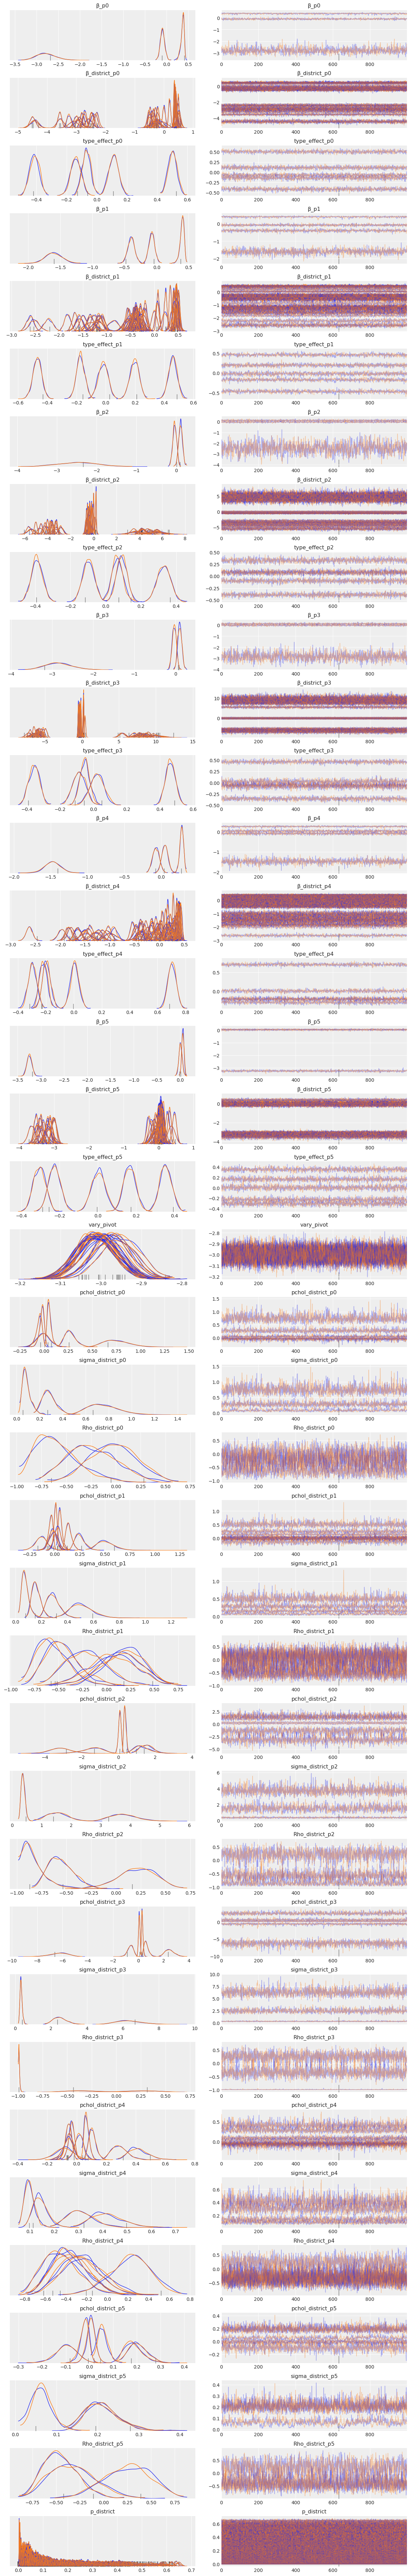

In [181]:
az.plot_trace(trace_dos_effects, compact=True);

In [182]:
share_est = trace_dos_effects["p_district"]
share_mean = share_est.mean(0)

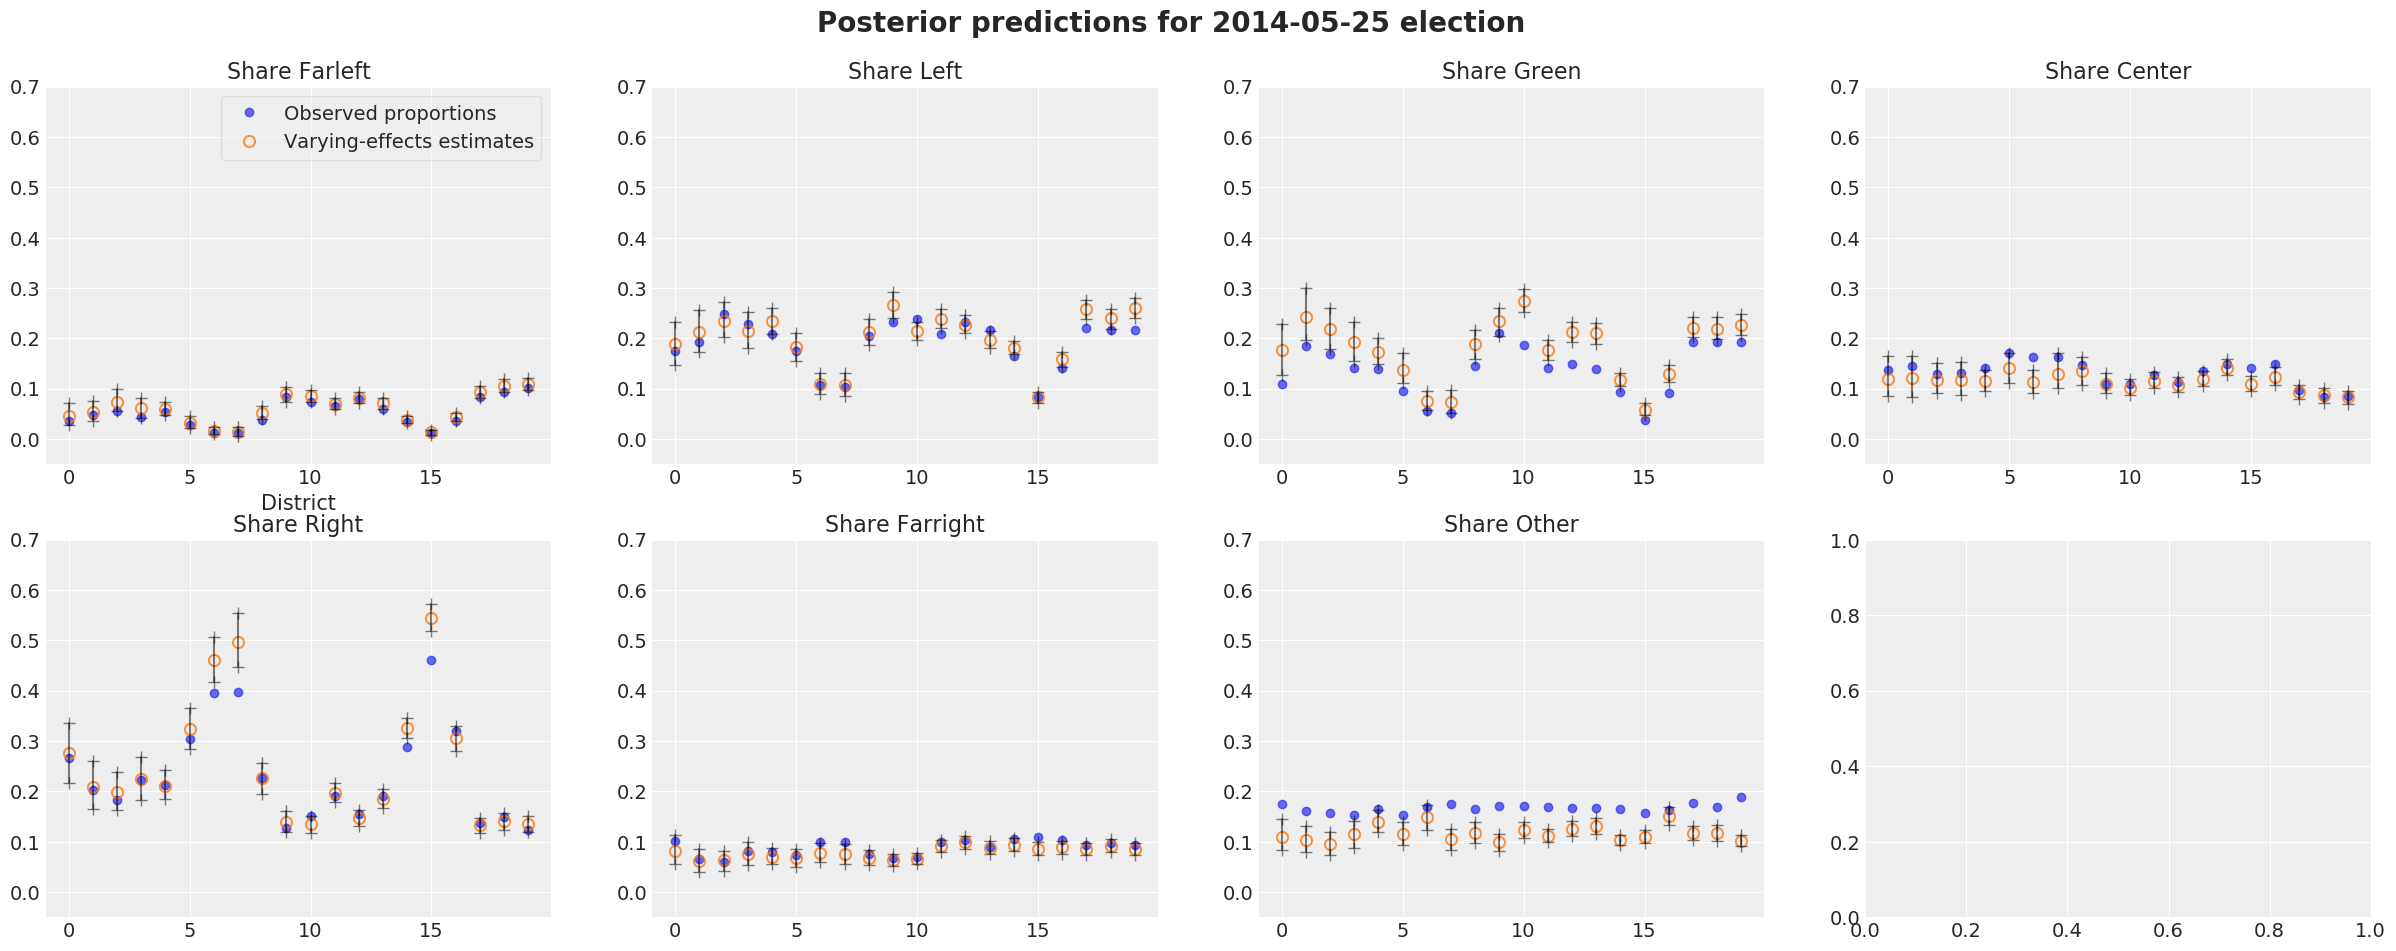

In [192]:
election = np.random.choice(d.date.unique(), replace=False)
election_mask = d.date == election
fig, axes = plt.subplots(2, 4, figsize=(30, 11))
for i, ax in enumerate(axes.flat):
    try:
        ax.plot(
            np.arange(Ndistricts),
            d.loc[election_mask, PARTIES[i]] / d.loc[election_mask, "N"],
            "o",
            ms=6,
            alpha=0.7,
            label="Observed proportions",
        )
        ax.plot(
            np.arange(Ndistricts),
            share_mean[election_mask, i],
            "o",
            fillstyle="none",
            ms=8,
            markeredgewidth=1.5,
            alpha=0.8,
            label="Varying-effects estimates",
        )
        ax.plot(
            [np.arange(Ndistricts), np.arange(Ndistricts)],
            az.hpd(share_est[:, election_mask, i], credible_interval=0.99).T,
            "k-+",
            ms=8,
            alpha=0.5,
        )
        ax.set_xticks(range(Ndistricts), range(1, Ndistricts + 1))
        ax.set_title(f"Share {PARTIES[i].title()}")
        ax.set_ylim([-0.05, 0.7])
        if i == 0:
            ax.set_xlabel("District")
            ax.legend(frameon=True, framealpha=0.5)
    except IndexError:
        continue
fig.suptitle(
    f"Posterior predictions for {np.datetime_as_string(election, unit='D')} election",
    y=0.95,
    size=20,
    weight="bold",
);

In [188]:
with open("trace_dos_effects.pkl", "wb") as f:
    pickle.dump(
        {"model": m_dos_effects, "trace": trace_dos_effects}, f
    )

In [111]:
with open("trace_dos_effects.pkl", "rb") as f:
    data = pickle.load(f)
m_dos_effects, trace_dos_effects = data["model"], data["trace"]

In [193]:
test_unemployment = ((np.log(unemp["2019Q2"]) - np.log(d["unemployment"]).mean()) / np.log(d["unemployment"]).std()).iloc[0, 0]
post_preds = []

for p_id, p in enumerate(PARTIES_AGG):
    test_polls = aggregated_polls.loc[aggregated_polls.dateelection == "2019-05-25", p].values[0]
    test_polls = (test_polls - d[p].mean()) / d[p].std()
    
    post_preds.append(
        trace_dos_effects[f"β_district_p{p_id}"][:, :, 0]
        + trace_dos_effects[f"type_effect_p{p_id}"][:, 0, None]
        + trace_dos_effects[f"β_district_p{p_id}"][:, :, 1] * test_unemployment
        + trace_dos_effects[f"β_district_p{p_id}"][:, :, 2] * test_polls
    )
post_preds = np.asarray(post_preds).T
post_preds.shape

(20, 2000, 6)

In [194]:
#vary_pivot = np.full(shape=(Ndistricts, 12_000, 1), fill_value=-3.0)
vary_pivot = trace_dos_effects["vary_pivot"].transpose([1, 0, 2])
post_preds = np.c_[post_preds, vary_pivot]
post_preds.shape

(20, 2000, 7)

In [195]:
share_est = softmax(post_preds, axis=2)
share_mean = share_est.mean(1)
share_est.shape

(20, 2000, 7)

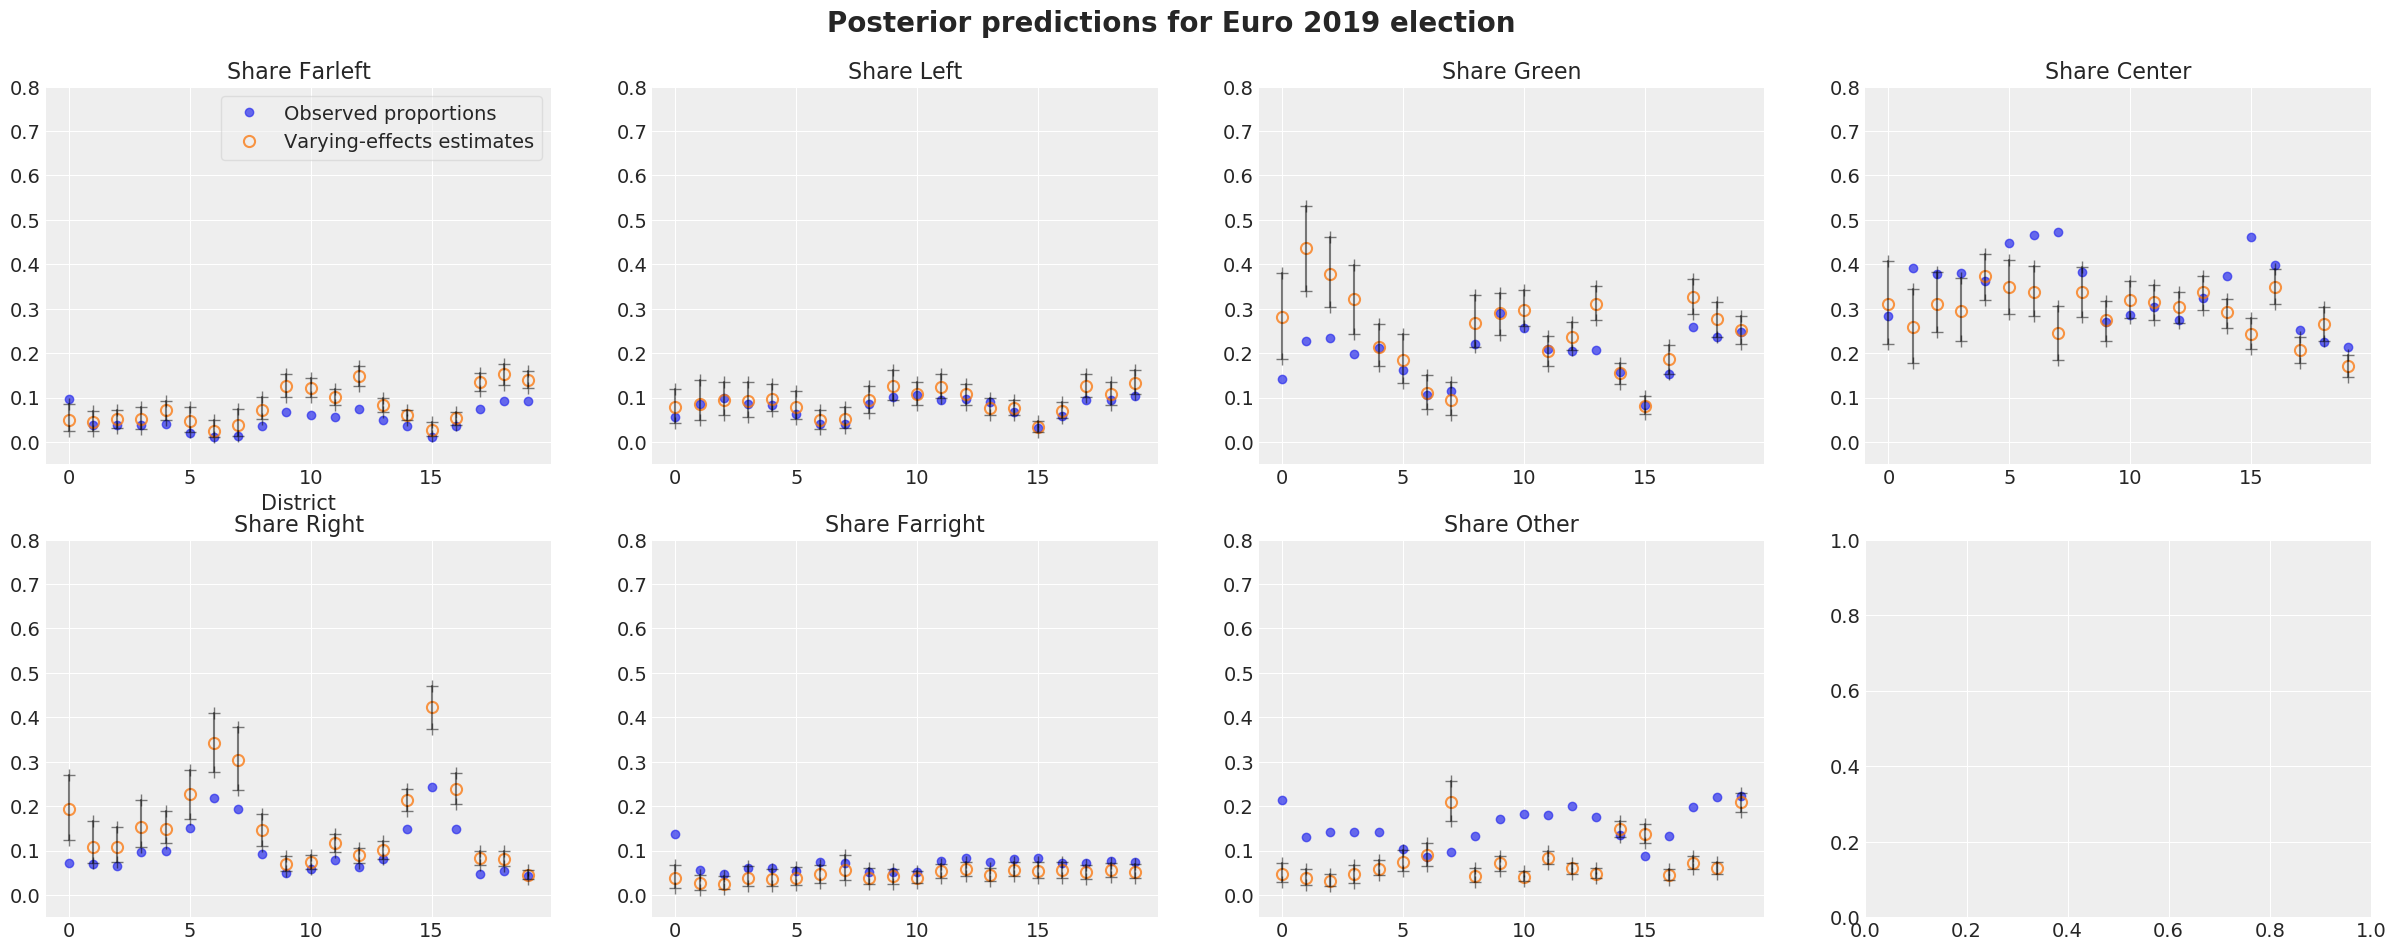

In [196]:
euro2019 = pd.read_excel("../data/raw_election_results_1st_round/euro2019-districts.xlsx", index_col=0)
fig, axes = plt.subplots(2, 4, figsize=(30, 11))
for i, ax in enumerate(axes.flat):
    try:
        ax.plot(
            np.arange(Ndistricts),
            euro2019[PARTIES[i]] / euro2019["N"],
            "o",
            ms=6,
            alpha=0.7,
            label="Observed proportions",
        )
        ax.plot(
            np.arange(Ndistricts),
            share_mean[:, i],
            "o",
            fillstyle="none",
            ms=8,
            markeredgewidth=1.5,
            alpha=0.8,
            label="Varying-effects estimates",
        )
        ax.plot(
            [np.arange(Ndistricts), np.arange(Ndistricts)],
            az.hpd(share_est[:, :, i].T, credible_interval=0.99).T,
            "k-+",
            ms=8,
            alpha=0.5,
        )
        ax.set_xticks(range(Ndistricts), range(1, Ndistricts + 1))
        ax.set_title(f"Share {PARTIES[i].title()}")
        ax.set_ylim([-0.05, 0.8])
        if i == 0:
            ax.set_xlabel("District")
            ax.legend(frameon=True, framealpha=0.5)
    except IndexError:
        continue
fig.suptitle(
    "Posterior predictions for Euro 2019 election",
    y=0.95,
    size=20,
    weight="bold",
);